### Import Aliyun python SDK modules

- `aliyun-python-sdk-core`
- `aliyun-python-sdk-ocr`
- `oss2`

In [1]:
#Aliyun SDK Core
from aliyunsdkcore.client import AcsClient
from aliyunsdkcore.acs_exception.exceptions import ClientException
from aliyunsdkcore.acs_exception.exceptions import ServerException

#Aliyun SDK OSS
import oss2

#Aliyun SDK OCR
from aliyunsdkocr.request.v20191230.RecognizeCharacterRequest import RecognizeCharacterRequest

### Configure Aliyun python SDK

In [2]:
#Access_key
access_key_id = 'LTAI4GGHnoZxjeprgmeiWdde'
access_key_secret = 'uDRC7ld9qiWXWQraWtqE9bFAC5Wfn8'

#OSS
endpoint = 'https://oss-cn-shanghai.aliyuncs.com'
bucket_name = 'unbinilium'

auth = oss2.Auth(access_key_id, access_key_secret)
bucket = oss2.Bucket(auth, endpoint, bucket_name)

#OCR
location = 'cn-shanghai'

client = AcsClient(access_key_id, access_key_secret, location)

### Instruct OCR request body, set return format to `json`

In [3]:
request = RecognizeCharacterRequest()
request.set_accept_format('json')

### Upload local image with SHA1 hashed name to OSS

- `image_path` is pointed to the local image
- image format should be `.png`
- image size should less than 3MB


In [4]:
import os
from hashlib import sha1

image_path = '../samples/example.png'

#Upload with SHA1 hashed name
filename, file_extension = os.path.splitext(image_path)
key = sha1(open(image_path, 'rb').read()).hexdigest() + file_extension
bucket.put_object_from_file(key, image_path)

import json

#Get image info from OSS
info = bucket.get_object(key, process = 'image/info')
info_content = info.read()
decoded_info = json.loads(oss2.to_unicode(info_content))

print('Image Info ->')
print(json.dumps(decoded_info, indent = 4, sort_keys = True))

#Struct image URL
image_url = 'https://' + bucket_name + '.' + endpoint.replace("https://","") + '/' + key

print('Image URL -> ' + image_url)

#Set OCR image_url
request.set_ImageURL(image_url)

Image Info ->
{
    "FileSize": {
        "value": "122767"
    },
    "Format": {
        "value": "png"
    },
    "ImageHeight": {
        "value": "480"
    },
    "ImageWidth": {
        "value": "720"
    }
}
Image URL -> https://unbinilium.oss-cn-shanghai.aliyuncs.com/8959756cc99f68b46a35af581539582d5ba7e478.png


### Send request and show OCR result

- `MinHeight` is set to $\frac{1}{20}$ of the image width
- `OutputProbability` is set to `true`

In [5]:
#Pre-config request
min_height = int(int(decoded_info['ImageHeight']['value']) / 20)
request.set_MinHeight(int(min_height))
request.set_OutputProbability(True)

#Send request to OCR server and get response
response = client.do_action_with_exception(request)

#Delete OSS image
bucket.delete_object(key)

import json

#Parse json response
parsed = json.loads(response)

print('Response ->')
print(json.dumps(parsed, indent = 4, sort_keys = True))

Response ->
{
    "Data": {
        "Results": [
            {
                "Probability": 0.6839849948883057,
                "Text": "identifier",
                "TextRectangles": {
                    "Angle": 0,
                    "Height": 48,
                    "Left": 396,
                    "Top": 89,
                    "Width": 224
                }
            },
            {
                "Probability": 0.9697373509407043,
                "Text": "font",
                "TextRectangles": {
                    "Angle": 0,
                    "Height": 52,
                    "Left": 90,
                    "Top": 106,
                    "Width": 121
                }
            },
            {
                "Probability": 0.22953228652477264,
                "Text": "Hello",
                "TextRectangles": {
                    "Angle": -1,
                    "Height": 68,
                    "Left": 276,
                    "Top": 193,
                    

### Parsed all `TextRectangle` and calculate the distance between image center and rect center

In [6]:
distances = []
objects = parsed['Data']['Results']

#Cal image center O(o_x0, o_y0)
o_x0, o_y0 = int(decoded_info['ImageWidth']['value']) / 2.0, int(decoded_info['ImageHeight']['value']) / 2.0

import math

for object in objects:
    
    #Cal TextRectangle angle A, start point A(x0, y0) and endpoint B(x1, y1)
    A = object['TextRectangles']['Angle'] / 180.0
    x0, y0 = object['TextRectangles']['Left'], object['TextRectangles']['Top']
    x1, y1 = x0 + object['TextRectangles']['Width'], y0 + object['TextRectangles']['Height']
    
    #Cal vector AB = (v_x0, v_y0)
    v_x0, v_y0 = x1 - x0, y1 - y0
    
    #Cal angle A rotated and 1/2 lenthed vector AB' = (v_x1, v_y1)
    v_x1, v_y1 = (v_x0 * math.cos(A) - v_y0 * math.sin(A)) / 2.0, (v_y0 * math.cos(A) + v_x0 * math.sin(A)) / 2.0
    
    #Cal TextRectangle center point B'(x2, y2)
    x2, y2 = x0 + v_x1, y0 + v_y1
    
    print('TextRectangleCtr -> ', (x2, y2))
    
    #Cal distance between point B and O
    d = math.pow(x2 - o_x0, 2) + math.pow(y2 - o_y0, 2)
    distances.append(d)

TextRectangleCtr ->  (508.0, 113.0)
TextRectangleCtr ->  (150.5, 132.0)
TextRectangleCtr ->  (365.18751446398215, 226.5050334089816)
TextRectangleCtr ->  (347.0, 353.0)


### Find the nearest `TextRectangle` index to the image center

In [7]:
index_min = distances.index(min(distances))

print('Min_Index -> ', index_min)

Min_Index ->  2


### Draw all `TextRectangle`

- ROI is **green** and others is **red**

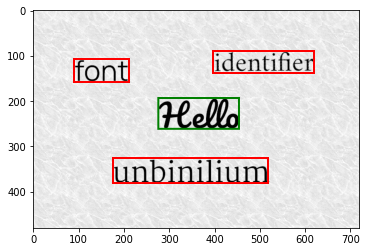

In [8]:
from matplotlib import pyplot as plt
from matplotlib import patches as patches

%matplotlib inline

img = plt.imread(image_path)

fig, ax = plt.subplots(1)
ax.imshow(img)

index = 0

for object in objects:
    if (index == index_min):
        c = 'g'
    else:
        c = 'r'
        
    index += 1
        
    ret = patches.Rectangle(
        (object['TextRectangles']['Left'], object['TextRectangles']['Top']),
        object['TextRectangles']['Width'],
        object['TextRectangles']['Height'],
        object['TextRectangles']['Angle'] / 180.0,
        linewidth = 2,
        edgecolor = c,
        facecolor = 'none'
    )
    
    ax.add_patch(ret)

plt.show()

### ROI

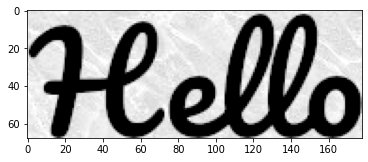

In [9]:
import PIL
from matplotlib import pyplot as plt

A = - objects[index_min]['TextRectangles']['Angle'] / 180.0

roi = PIL.Image.open(image_path)
roi = roi.rotate(A)

def rotate(x, y, o_x, o_y, theta):
    x_r = math.cos(theta) * (x - o_x) - math.sin(theta) * (y - o_y) + o_x
    y_r = math.sin(theta) * (x - o_x) + math.cos(theta) * (y - o_y) + o_y
    return [x_r, y_r]

#Cal start point A(x0, y0)
x0, y0 = objects[index_min]['TextRectangles']['Left'], objects[index_min]['TextRectangles']['Top']

#Cal angle A rotated A'(x1, y1)
x1, y1 = rotate(x0, y0, o_x0, o_y0, A)

roi = roi.crop((x1, y1, (x1 + objects[index_min]['TextRectangles']['Width']), (y1 + objects[index_min]['TextRectangles']['Height'])))

fig, ax = plt.subplots(1)
ax.imshow(roi)

plt.show()

### Load image function for DeepFont

- color to gray
- resize to (105, 105)

In [10]:
import PIL
import numpy as np

def pil_image(img_path):
    pil_img = PIL.Image.open(img_path).convert('L')
    pil_img = pil_img.resize((105, 105))
    return pil_img

### Preprocessing function

- Noise a small Gaussian noise with 0 mean and standard deviation 3 is added to input.
- Blur a random Gaussian blur with standard deviation from 2.5 to 3.5 is added to input.
- Perspective Rotation a randomly-parameterized affine transformation is added to input.
- Shading the input background is filled with a gradient in illumination.

In [11]:
import PIL
import cv2
import numpy as np

def noise_image(img):
    img_array = np.asarray(img)
    mean = 0.0
    std = 3
    noisy_img = img_array + np.random.normal(mean, std, img_array.shape)
    noisy_img_clipped = np.clip(noisy_img, 0, 255)
    noise_img = PIL.Image.fromarray(np.uint8(noisy_img_clipped))
    noise_img = noise_img.resize((105, 105))
    return noise_img

def blur_image(img):
    blur_img = img.filter(PIL.ImageFilter.GaussianBlur(radius = 3))
    blur_img = blur_img.resize((105, 105))
    return blur_img

def affine_rotation(img):
    rows, columns = img.shape
    point1 = np.float32([[10, 10], [30, 10], [10, 30]])
    point2 = np.float32([[20, 15], [40, 10], [20, 40]])
    anchor = cv2.getAffineTransform(point1, point2)
    output = cv2.warpAffine(img, anchor, (columns, rows))
    affine_img = PIL.Image.fromarray(np.uint8(output))
    affine_img = affine_img.resize((105, 105))
    return affine_img

def gradient_fill(img):
    output = cv2.Laplacian(img, cv2.CV_64F)
    laplacian_img = PIL.Image.fromarray(np.uint8(output))
    laplacian_img = laplacian_img.resize((105, 105))
    return laplacian_img

### Generate Datasets

- `ttf_path` is a folder contains all the font file with correct font name and `.ttf` extension
- `data_path` is a folder stores or contains generated datasets

Uses `TextRecognitionDataGenerator`

In [12]:
import os

ttf_path = '../fonts'
data_path = '../datasets'

for file in os.listdir(ttf_path):
    if file.endswith('.ttf'):
        path = os.path.join(ttf_path, file)
        name, ext = os.path.splitext(os.path.basename(path))
        out_path = data_path + '/' + name
        command = 'trdg -l en -c 10 -rs -let -num -r --length 1 -b 1 -e .png -fi -f 105 -ft ' + path + ' --output_dir ' + out_path 
        os.system(command)

### Import Datasets

- `label_path` should be defined

In [13]:
import os
import json
from imutils import paths
from random import seed, shuffle

label_path = '../models/labels.json'

#Random image path from data_path
image_paths = sorted(list(paths.list_images(data_path)))
seed(10)
shuffle(image_paths)

#Use folder name in data_path as font name
font_names = []

for f in os.listdir(data_path):
    if not f.startswith('.'):
        font_names.append(f)
        
font_names.sort()

with open(label_path, 'w') as outfile:
    json.dump(font_names, outfile)

print('Font Names -> ', font_names)

Font Names ->  ['Amiri-Regular', 'Manrope-Regular', 'Martel-Regular', 'Pacifico-Regular', 'Sacramento-Regular']


### Labeling font by the index of font name in `font_names`

In [14]:
def conv_label(label):
    return font_names.index(label)

### Preprocessing Datasets

In [15]:
import os
import itertools
import numpy as np
from keras.preprocessing.image import img_to_array

data = []
labels = []
auguments = ["blur", "noise", "affine", "gradient"]

for path in image_paths:
    
    #Labeling images
    label = path.split(os.path.sep)[-2]
    
    if not label.startswith('.'):
        label = conv_label(label)
    else:
        continue
    
    pil_img = pil_image(path)
    org_img = img_to_array(pil_img)
    
    data.append(org_img)
    labels.append(label)
    
    #Random auguments combinations
    for i in range(0, len(auguments)):
        for augument in list(itertools.combinations(auguments, i + 1)):
            
            temp_img = pil_img
            combinations = list(augument)
            
            for method in combinations:
                if method == 'noise':
                    temp_img = noise_image(temp_img)
                    
                elif method == 'blur':
                    temp_img = blur_image(temp_img)
                    
                elif method == 'affine':
                    open_cv_affine = np.array(pil_img)
                    temp_img = affine_rotation(open_cv_affine)

                elif method == 'gradient':
                    open_cv_gradient = np.array(pil_img)
                    temp_img = gradient_fill(open_cv_gradient)
  
            temp_img = img_to_array(temp_img)
    
            data.append(temp_img)
            labels.append(label)

### Partition Datasets and transform

- $\frac{3}{4}$ for training
- $\frac{1}{4}$ for testing

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

#Partition
data = np.asarray(data, dtype = "float") / 255.0
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size = 0.25, random_state = 10)

#Converting labels from integers to vectors
trainY = to_categorical(trainY, num_classes = 5)
testY = to_categorical(testY, num_classes = 5)

### Additional Datasets process

- **Variable Character Spacing** when rendering each synthetic image, set the character spacing (by pixel) to be a Gaussian random variable of mean 10 and standard deviation 40, bounded by [0, 50].
- **Variable Aspect Ratio** Before cropping each image into a input patch, the image, with heigh fixed, is squeezed in width by a random ratio, drawn from a uniform distribution between $\frac{5}{6}$ and $\frac{7}{6}$.

In [17]:
from keras.preprocessing.image import ImageDataGenerator

augmented_images = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

### Re-arrange Datasets channels

In [18]:
from keras import backend as K

K.set_image_data_format('channels_last')

### Create model

- **Unsupervised cross-domain sub-network ${C_u}$**, which consists of the first *K* layers of *CNN*. It accounts for extracting low-level visual features shared by both syn- thetic and real-world data domains. ${C_u}$ will be trained in a unsupervised way, using unlabeled data from both domains. It constitutes the crucial step that further minimizes the low-level feature gap, beyond the previous data augmentation efforts.

- **Supervised domain-specific sub-network ${C_s}$**, which consists of the remaining *N − K* layers. It accounts for learning higher-level discriminative features for classi- fication, based on the shared features from ${C_u}$. ${C_s}$ will be trained in a supervised way, using labeled data from the synthetic domain only.

In [19]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D , UpSampling2D ,Conv2DTranspose

def create_model():
    model = Sequential()

    #Cu Layers 
    model.add(Conv2D(64, kernel_size = (48, 48), activation = 'relu', input_shape = (105, 105, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(128, kernel_size = (24, 24), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    
    model.add(Conv2DTranspose(128, (24, 24), strides = (2, 2), activation = 'relu', padding = 'same', kernel_initializer = 'uniform'))
    model.add(UpSampling2D(size = (2, 2)))

    model.add(Conv2DTranspose(64, (12, 12), strides = (2, 2), activation = 'relu', padding = 'same', kernel_initializer = 'uniform'))
    model.add(UpSampling2D(size = (2, 2)))

    #Cs Layers
    model.add(Conv2D(256, kernel_size=(12, 12), activation = 'relu'))
    model.add(Conv2D(256, kernel_size=(12, 12), activation = 'relu'))
    model.add(Conv2D(256, kernel_size=(12, 12), activation = 'relu'))

    model.add(Flatten())
    model.add(Dense(4096, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2383, activation = 'relu'))
    model.add(Dense(5, activation = 'softmax'))
 
    return model

### Compile Model

In [20]:
from keras import optimizers

batch_size = 128
epochs = 50
model= create_model()
opt = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(loss = 'mean_squared_error', optimizer = opt, metrics = ['accuracy'])

### Fit and store Model

- `model_path` should be defined

In [21]:
from keras import callbacks

model_path = '../models/keras.h5'

my_callbacks = [
    callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 0, mode = 'min'),
    callbacks.ModelCheckpoint(model_path, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')
]

model.fit(
    trainX,
    trainY,
    shuffle = True,
    batch_size = batch_size,
    epochs = epochs,
    verbose = 1,
    validation_data = (testX, testY),
    callbacks = my_callbacks
)

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 0.1572 - accuracy: 0.2450 
Epoch 00001: val_loss improved from inf to 0.16011, saving model to /home/unbinilium/Documents/font-identifier/models/keras.h5
5/5 [==============================] - 159s 32s/step - loss: 0.1572 - accuracy: 0.2450 - val_loss: 0.1601 - val_accuracy: 0.1800
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 0.1509 - accuracy: 0.3917 
Epoch 00002: val_loss did not improve from 0.16011
5/5 [==============================] - 156s 31s/step - loss: 0.1509 - accuracy: 0.3917 - val_loss: 0.1603 - val_accuracy: 0.1800
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 0.1460 - accuracy: 0.3683 
Epoch 00003: val_loss did not improve from 0.16011
5/5 [==============================] - 157s 31s/step - loss: 0.1460 - accuracy: 0.3683 - val_loss: 0.1601 - val_accuracy: 0.1350
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 0.1360 - accuracy: 0.4733 
Epoch 00004:

###  Evaluate

In [22]:
from keras.models import load_model

model_path = '../models/keras.h5'

model = load_model(model_path)
score = model.evaluate(testX, testY, verbose = 0)

print('Test loss ->', score[0])
print('Test accuracy ->', score[1])

Test loss -> 0.14496561884880066
Test accuracy -> 0.5


### Revert font name from labels

In [23]:
def rev_conv_label(label):
    return font_names[label]

### Verify

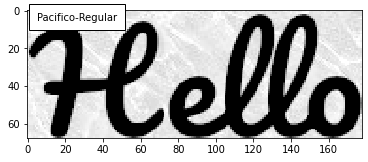

In [24]:
import PIL
import numpy as np
import matplotlib.cm as cm
import matplotlib.pylab as plt
from keras.preprocessing.image import img_to_array

#Load image and de-noisy
tmp_img = roi.copy().convert('L')
tmp_img = blur_image(tmp_img)
arr_img = img_to_array(tmp_img)

#Predict using trained model
data = []
data.append(arr_img)
data = np.asarray(data, dtype = "float") / 255.0
y = model.predict_classes(data)

#Display result
label = rev_conv_label(int(y[0]))
fig, ax = plt.subplots(1)
ax.imshow(roi, interpolation = 'nearest', cmap = cm.gray)
ax.text(5, 5, label, bbox = {'facecolor': 'white', 'pad': 8})
plt.show()